In [1]:
#%matplotlib widget

In [1]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=2024

### Define functions

In [2]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [5]:
def get_fr_samples(sp,sample_id,start,end,samples,rng,n_trials,seed):
    # parameters
    rng = np.random.default_rng(seed=seed)
    # Check fr
    # ms_fr=np.nanmean(sp[:,start:end])*1000>3
    # if not ms_fr:
    #     return None
    # Average spikes
    avg_sample = sp#firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        trials_list = rng.choice(sample_fr.shape[0], size=n_trials, replace=False)
        fr_samples.append(sample_fr[trials_list])
    return np.array(fr_samples)

In [6]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<50:
        return {'fr':None}
    #non_zero_mask = np.sum(sp_sample_on[:,idx_start:idx_end],axis=1)>0
    sample_id = neu_data.sample_id[mask]#[non_zero_mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],rng=rng)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [7]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [8]:
def get_fr_nksmt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_noneu = neu_data.sample_id[mask_test1]!=0
    mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
    mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
    if np.sum(mask_noneu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
    fr_samples_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

    sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
    fr_samples_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    
    if fr_samples_match is None:
        return {'fr':None}
    if fr_samples_nonmatch is None:
        return {'fr':None}
    fr_samples = np.array([fr_samples_match,fr_samples_nonmatch])
    return {'fr':fr_samples}

In [9]:
def select_trials(neu_data,select_block,code,time_before,error_type=0):
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= error_type,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= error_type,
    )
    if np.any(mask_sample != mask_test1):
        return "error"
    return sp_sample_on,sp_test1_on,mask_sample,mask_test1

In [10]:
# will not have enough error trials
def get_fr_nksmdt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=0)
    
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_noneu = neu_data.sample_id[mask_test1]!=0
    mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
    mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
    if np.sum(mask_noneu)<20:
        return {'fr':None}
    
    # Correct desition Match
    sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
    fr_samples_correct_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Correct desition Non-Match
    sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
    fr_samples_correct_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Incorrect desition Match
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=8)
    sp=np.concatenate((sp_sample_on[:,:time_before+450+200],sp_test1_on[:,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1]
    fr_samples_incorrect_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Incorrect desition Match
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=6)
    sp=np.concatenate((sp_sample_on[:,:time_before+450+200],sp_test1_on[:,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1]
    fr_samples_incorrect_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

    if fr_samples_correct_match is None:
        return {'fr':None}
    if fr_samples_correct_nonmatch is None:
        return {'fr':None}
    if fr_samples_incorrect_match is None:
        return {'fr':None}
    if fr_samples_incorrect_nonmatch is None:
        return {'fr':None}
    fr_samples = np.array([[fr_samples_correct_match,fr_samples_correct_nonmatch],[fr_samples_incorrect_match,fr_samples_incorrect_nonmatch]])
    return {'fr':fr_samples}

In [11]:
def get_fr_nksmrt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed): 
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    idx_start = time_before + start 
    idx_end = time_before+end
    pos_fr=[]
    for pos in [1,-1]:    
        # Select trials aligned to sample onset
        sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,pos,time_before,error_type=0) 
        
        mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
        mask_noneu = neu_data.sample_id[mask_test1]!=0
        mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
        mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
        if np.sum(mask_noneu)<20:
            return {'fr':None}
    
        sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
        sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
        fr_samples_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

        sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
        sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
        fr_samples_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
        
        if fr_samples_match is None:
            return {'fr':None}
        if fr_samples_nonmatch is None:
            return {'fr':None}
        pos_fr.append(np.array([fr_samples_match,fr_samples_nonmatch]))
    fr_samples = np.array(pos_fr)
    return {'fr':fr_samples}

### Read data

In [12]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [13]:
area='v4'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [39]:
# Load data
n_test=1
time_before=500
start=-400
end_test = n_test*450+200
end=450+200+200+end_test
n_trials=10
idx_start = time_before + start 
idx_end = time_before+end
T=end-start
T

1900

In [40]:
rng = np.random.default_rng(seed=seed)
seed_list = rng.choice(3000, size=len(path_list), replace=False)
data = Parallel(n_jobs = -1)(delayed(get_fr_nksmt)(path_list[i],time_before,start,end,end_test,n_test,rng,n_trials,seed_list[i]) for i in tqdm(np.arange(len(path_list))))

100%|██████████| 530/530 [11:46<00:00,  1.33s/it]


In [41]:
X_all = []
N = 0
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        N+=1
        X_all.append(fr)
#to_python_hdf5(dat=X_full, save_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')

In [42]:
# X_full_read=from_python_hdf5(load_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')
# X_full = []
# for asc in X_full_read:
#     fr = asc["fr"]
#     if fr is not None:
#         fr_concat = np.concatenate(fr,axis=0)
#         X_full.append(fr_concat)

In [43]:
np.array(X_all).shape

(374, 2, 4, 10, 1900)

In [44]:
X_fr_raw = np.array(X_all)#.reshape(-1,1050)
X_fr_raw =np.transpose(X_fr_raw,(3,0,2,1,4))#np.transpose(X_fr_raw,(4,0,1,2,3,5))#
X_fr_raw.shape

(10, 374, 4, 2, 1900)

In [45]:
basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'/'
path = basepath + 'fr_dpca_'+ area +'_trials_' + str(n_trials)+'_no_fr_filt' + '_nksmt.hs'
if not os.path.isfile(path):
    to_python_hdf5(dat=[{'pp':X_fr_raw}], save_path=path)

In [46]:
X_fr_raw = from_python_hdf5(path)[0]['pp']#
X_fr_raw.shape

(10, 374, 4, 2, 1900)

In [47]:
X_fr = firing_rate.convolve_signal(arr=X_fr_raw,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)[:,:,:,:,200:1500+200]
X_fr.shape

(10, 374, 4, 2, 1500)

In [48]:
N=X_fr.shape[1]
# trial-average data
X = np.mean(X_fr,0)
# center data
#X -= np.mean(X.reshape((N,-1)),1)[:,None,None]
print(X.shape)

(374, 4, 2, 1500)


In [49]:
dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt' : ['sm','smt']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
#dpca = dPCA.dPCA(labels='rmst',join= {'rt' : ['r','rt'],'mt' : ['m','mt'],'st' : ['s','st'],'rmt' : ['rm','rmt'],'rst' : ['rs','rst'],'mst' : ['ms','mst'],'rmst' : ['rms','rmst']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
dpca.protect = ['t']
#dpca.n_trials = 3
comp = dpca.fit_transform(X,X_fr)

In [50]:
list(comp.keys())

['t', 'st', 'mt', 'smt']

In [51]:
variances = dpca.get_variances(X)

In [52]:
variances['total_marg_var']

{'t': 158396756.4304139,
 'st': 35870914.640103064,
 'mt': 17710754.288632262,
 'smt': 25978759.502933335}

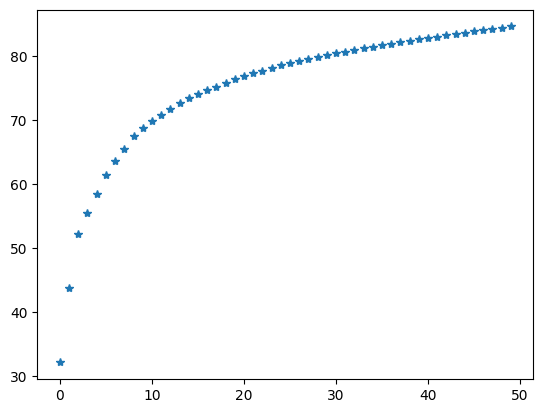

In [53]:
plt.plot(variances['cumulative_var'][:50],'*')
# trial-average data
X_full = np.mean(X_fr,0)
X = X_full.reshape((N,-1))
X_cen = X- np.mean(X,1)[:,None]

In [54]:
samples={
    "o1_c1": 0,
    "o1_c5": 1,
    "o5_c5": 2,
    "o5_c1": 3,
}

In [55]:
marg_var_t = variances['marg_var']['t']
#marg_var_rt = variances['marg_var']['rt']
marg_var_st = variances['marg_var']['st']
marg_var_mt = variances['marg_var']['mt']
marg_var_smt = variances['marg_var']['smt']
# marg_var_rmt = variances['marg_var']['rmt']
# marg_var_rst = variances['marg_var']['rst']
# marg_var_mst = variances['marg_var']['mst']
# marg_var_rmst = variances['marg_var']['rmst']

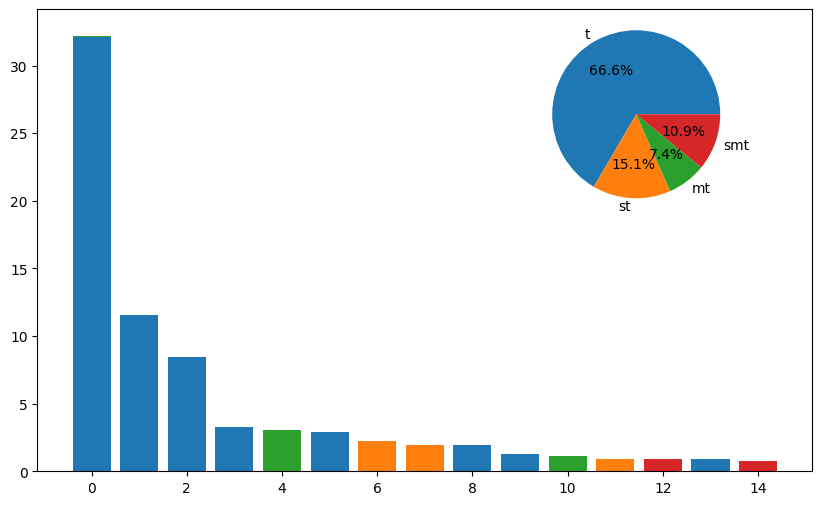

In [56]:
n_comp=15
t_var = np.array(marg_var_t[:n_comp])
#rt_var = np.array(marg_var_rt[:n_comp])
st_var = np.array(marg_var_st[:n_comp])
mt_var = np.array(marg_var_mt[:n_comp])
smt_var = np.array(marg_var_smt[:n_comp])
#smt_var = np.array(marg_var_mst[:n_comp])
#smt_var = np.array(marg_var_mst[:n_comp])
#smt_var = np.array(marg_var_mst[:n_comp])

f,ax = plt.subplots(figsize=(10,6))
#ax.bar(range(n_comp),s_var, label='s')
ax.bar(range(n_comp),t_var, label='t')
#ax.bar(range(n_comp),rt_var, bottom= t_var, label='t')

ax.bar(range(n_comp),st_var, bottom= (t_var), label='st')
ax.bar(range(n_comp),mt_var, bottom= (t_var+st_var), label='mt')
ax.bar(range(n_comp),smt_var, bottom= (t_var+st_var+mt_var), label='smt')#+sm_var
#ax.legend()
ax.set_ylim(0,(t_var+st_var+mt_var+smt_var)[0]+2)
# f,ax = plt.subplots(figsize=(3,3))
ax2 = plt.subplot2grid((2, 2), (0, 1))
_=ax2.pie([variances['total_marg_var']['t'],variances['total_marg_var']['st'],variances['total_marg_var']['mt'],variances['total_marg_var']['smt']],labels=['t','st','mt','smt'],autopct='%1.1f%%')

In [57]:
Z_full = X_cen.T@dpca.D_sorted
which_marg=variances['which_marg']
components =np.concatenate([np.where(which_marg==i)[0][:3] for i in list(comp.keys())])
Z= Z_full.T[components].reshape(np.concatenate((components.shape,X_full.shape[1:])))
Z.shape

(12, 4, 2, 1500)

In [58]:
samples

{'o1_c1': 0, 'o1_c5': 1, 'o5_c5': 2, 'o5_c1': 3}

In [59]:
which_marg[components]

array(['t', 't', 't', 'st', 'st', 'st', 'mt', 'mt', 'mt', 'smt', 'smt',
       'smt'], dtype='<U3')

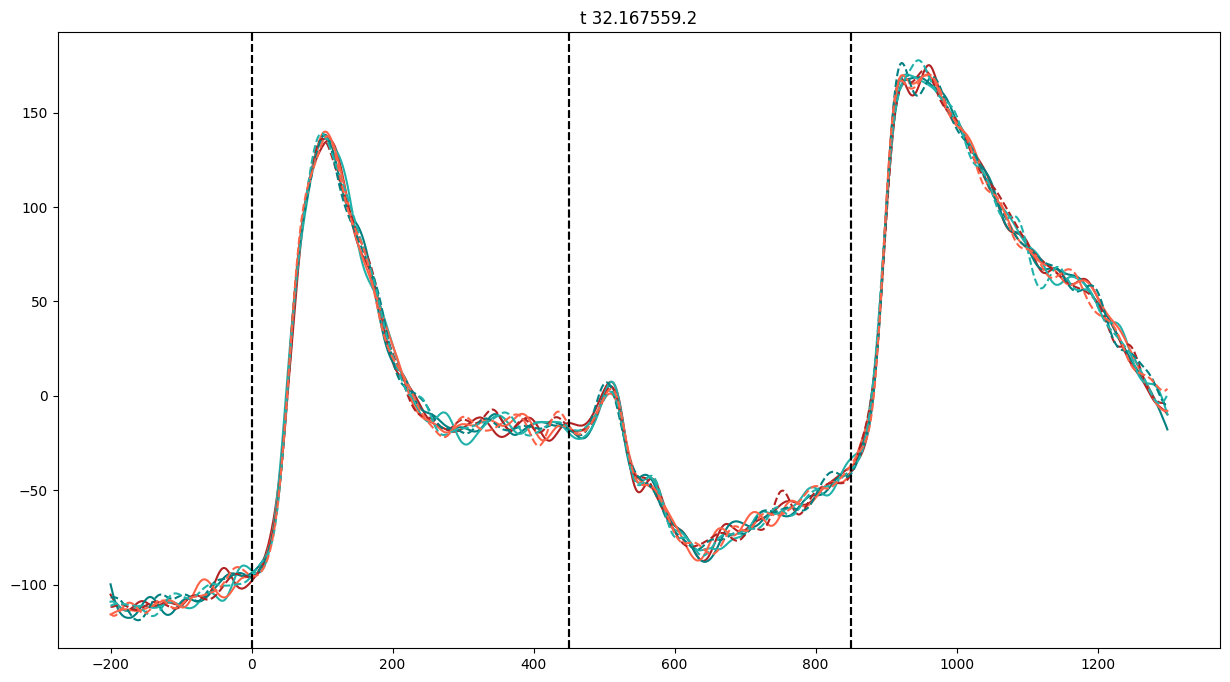

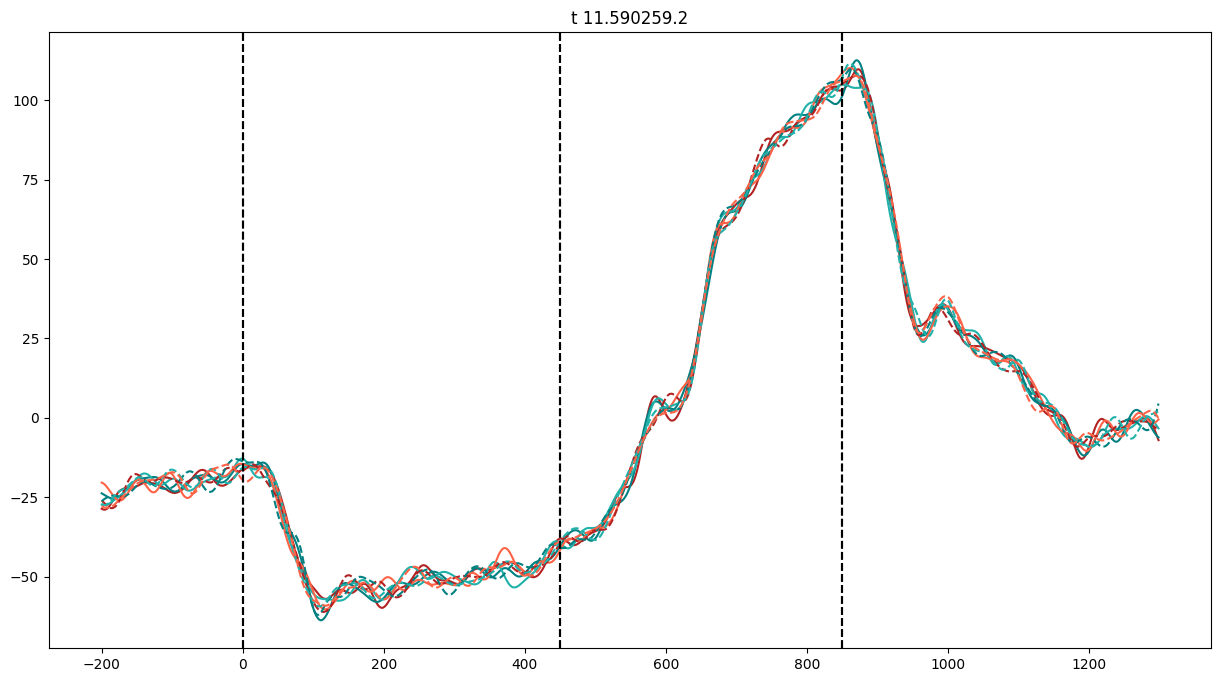

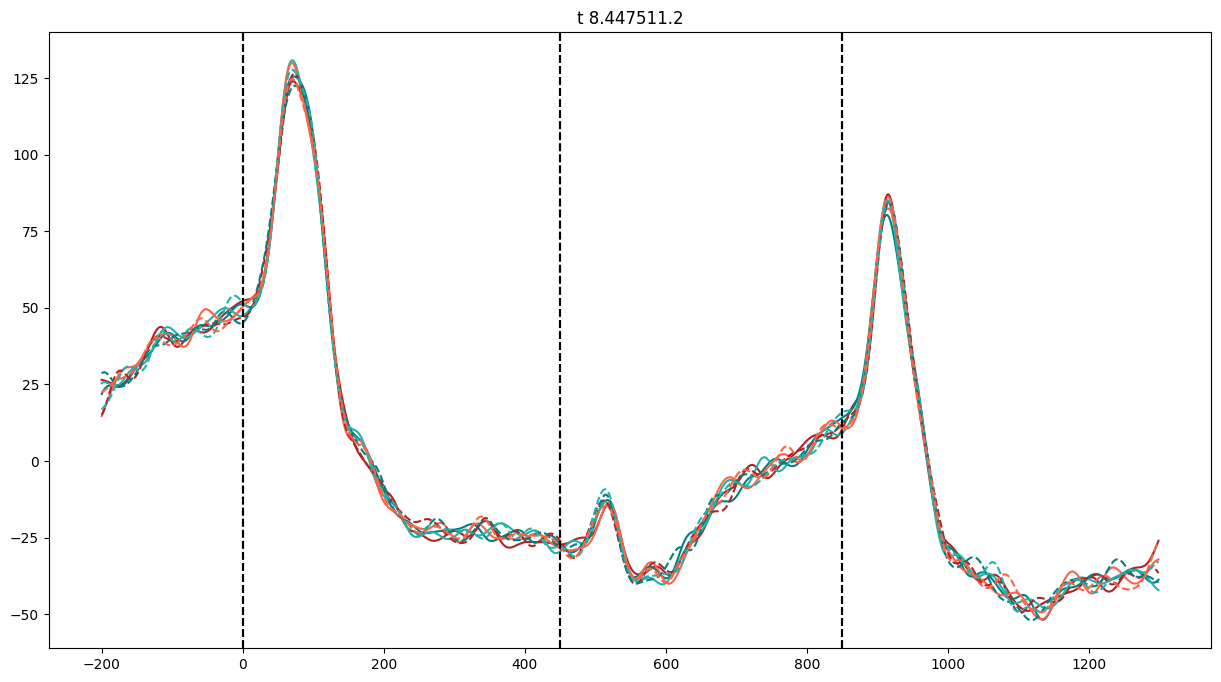

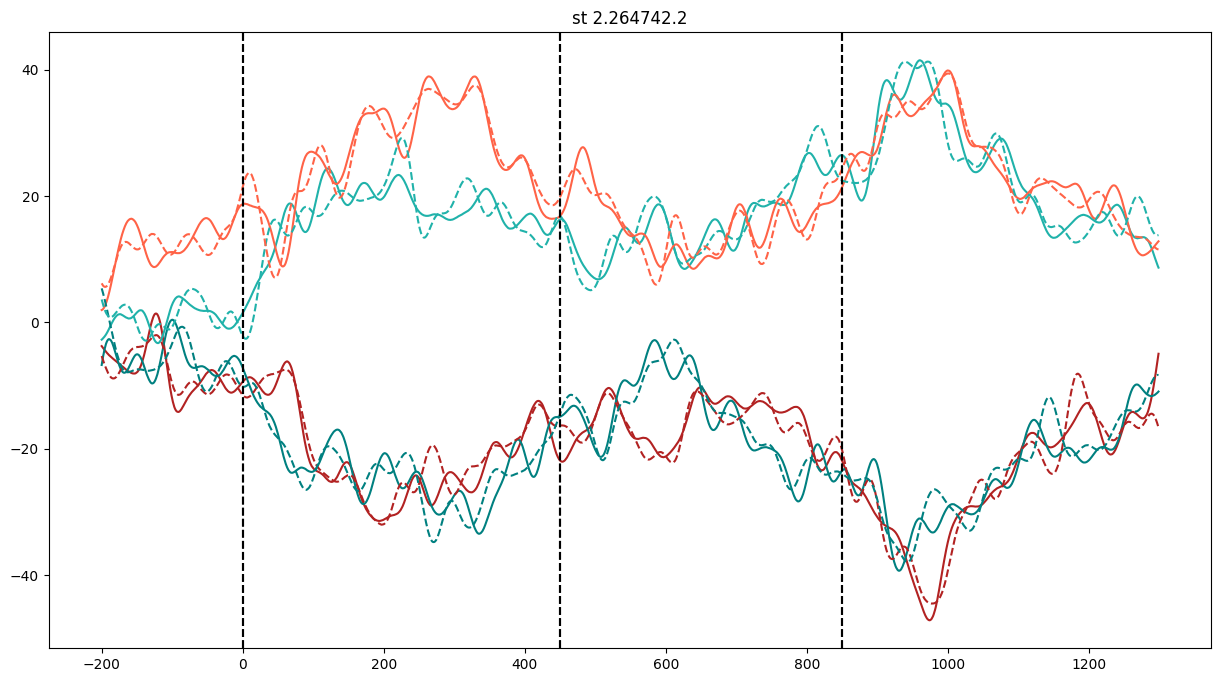

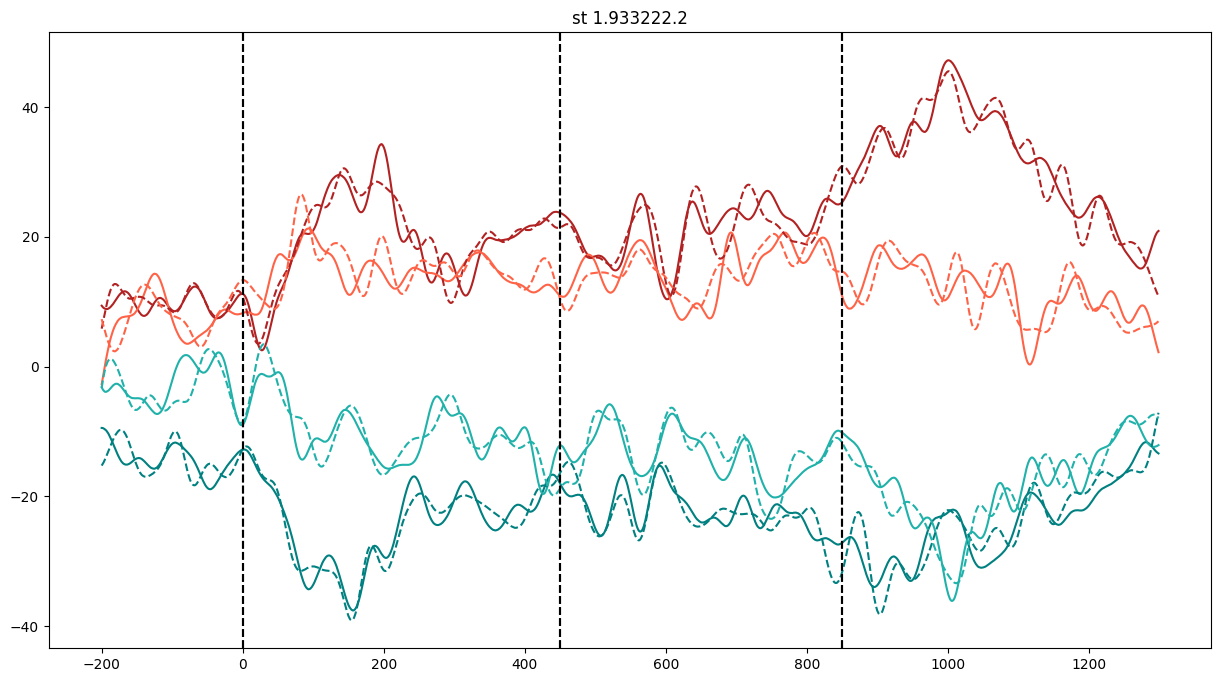

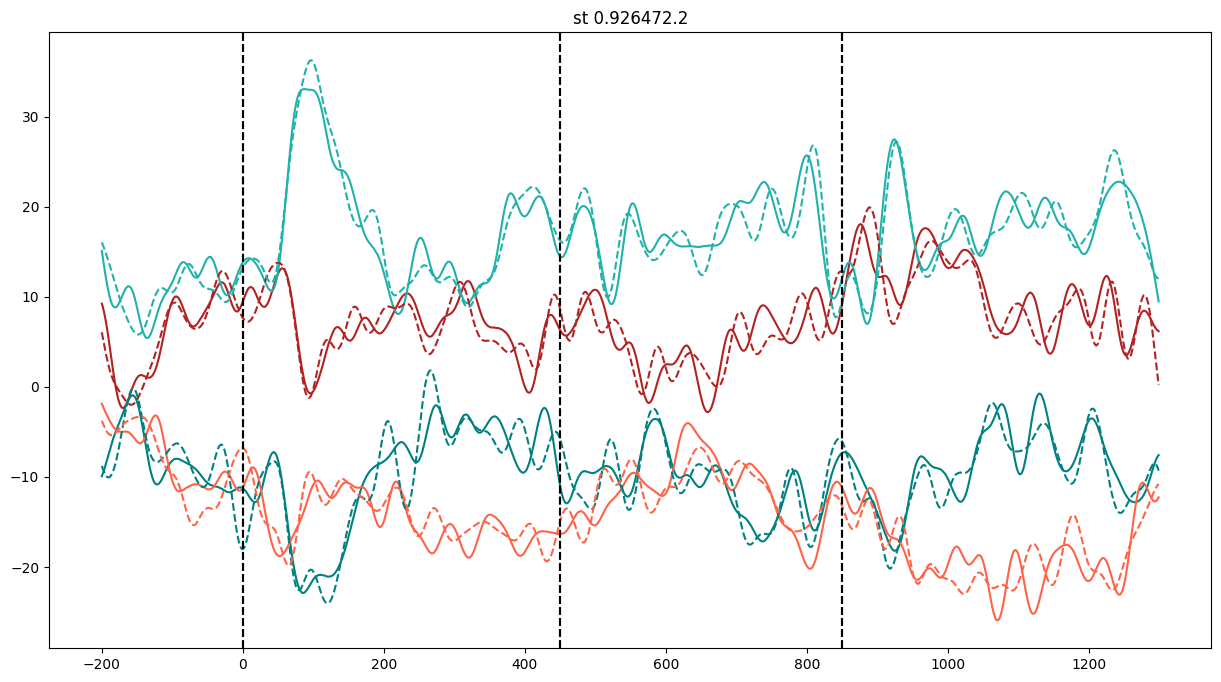

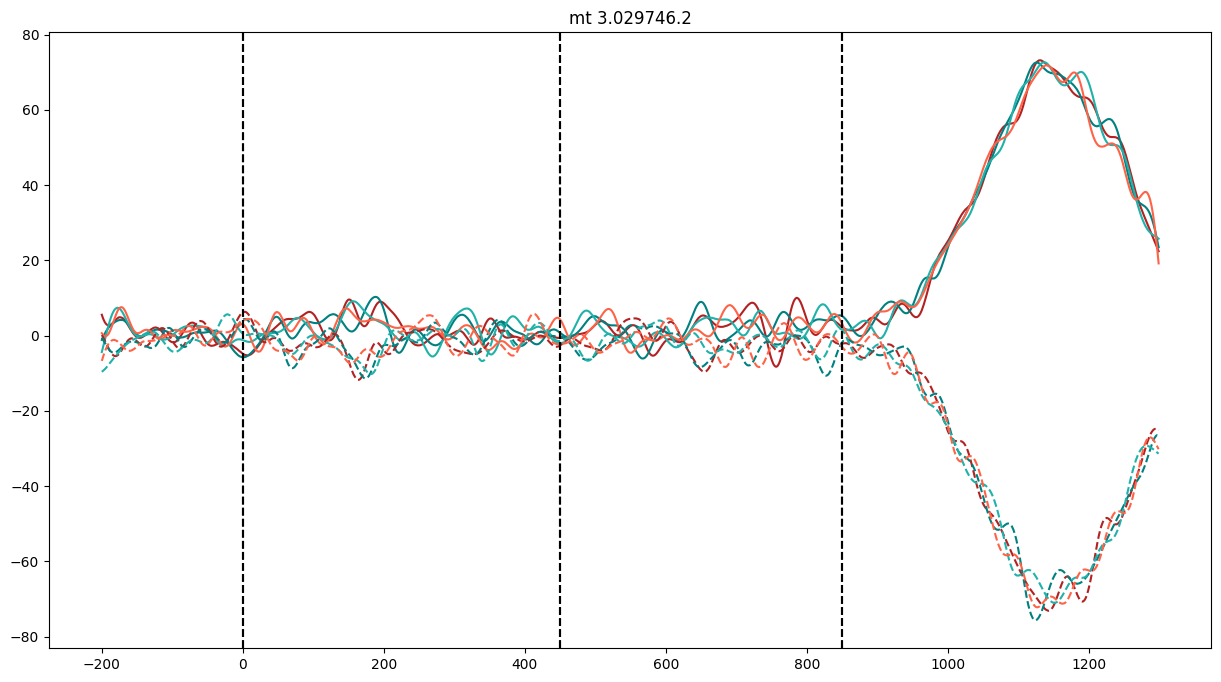

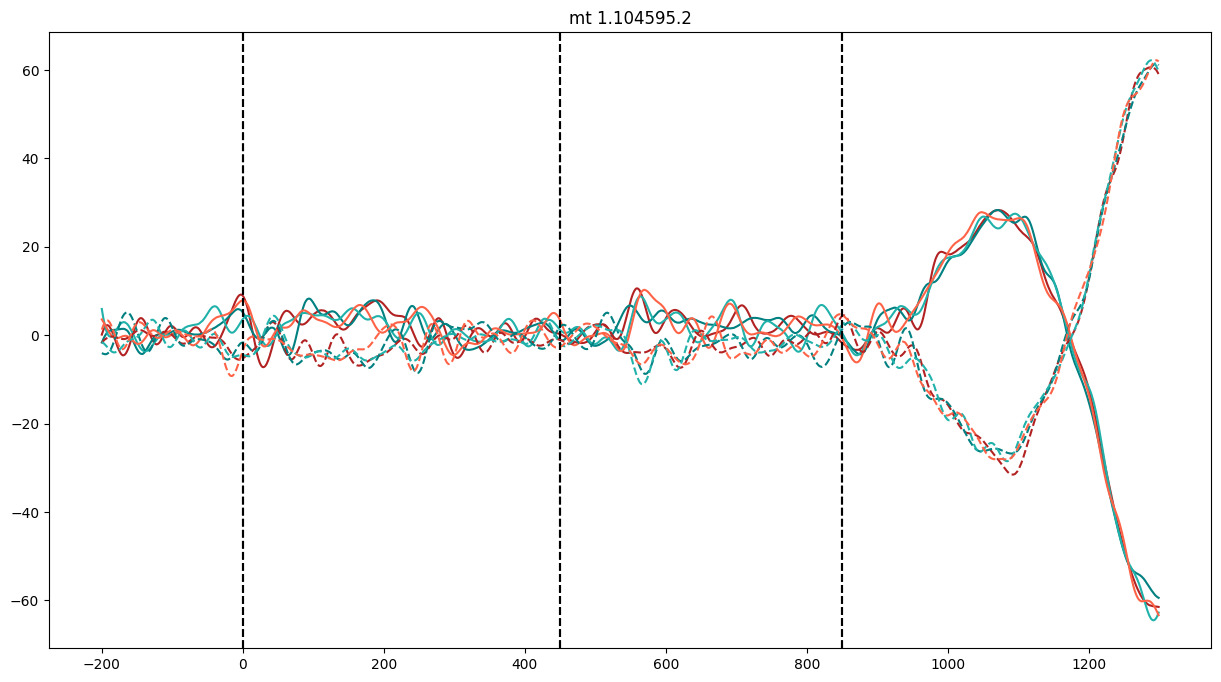

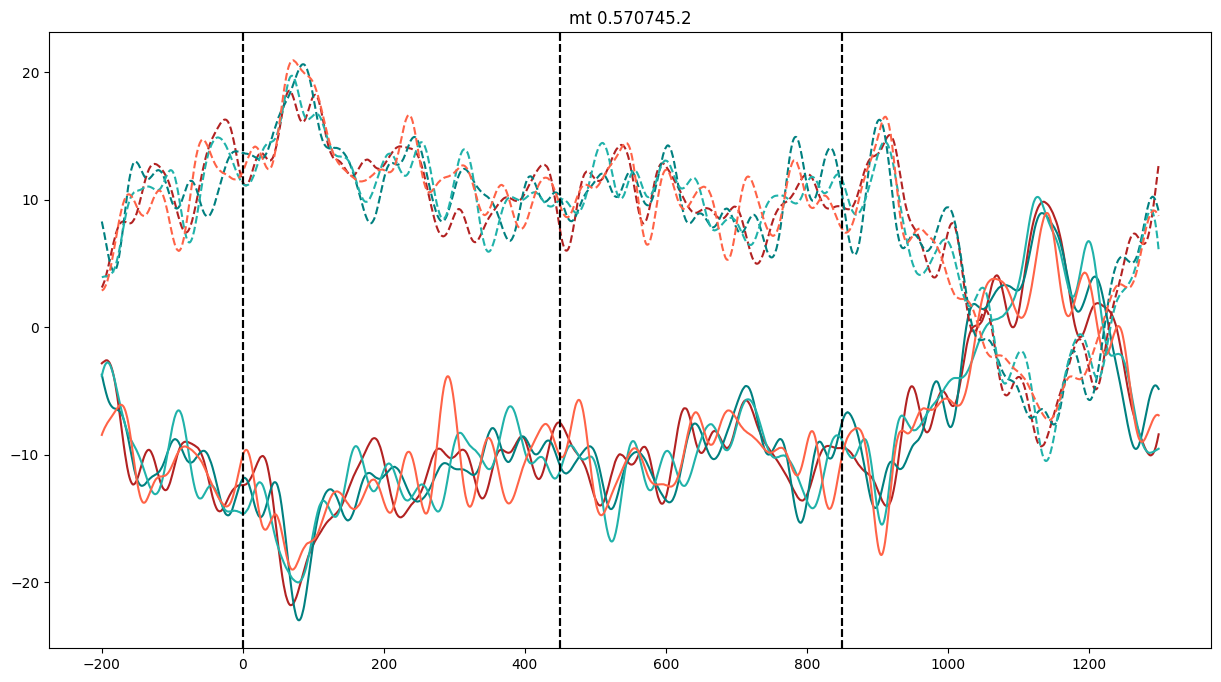

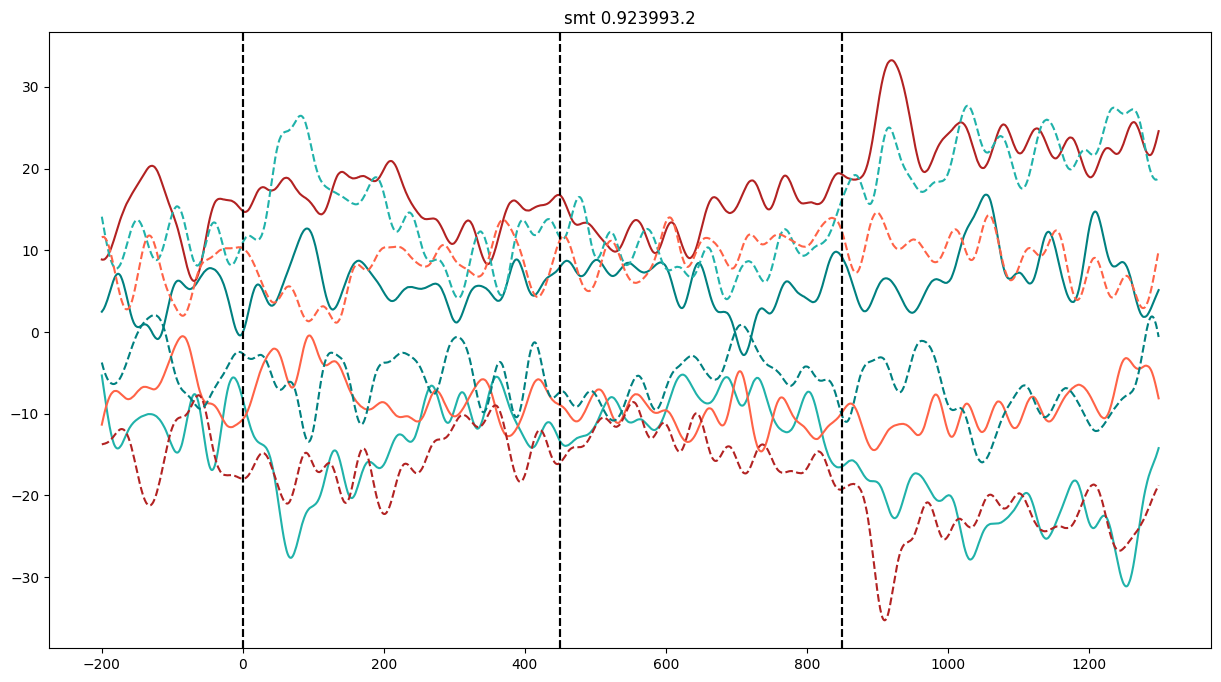

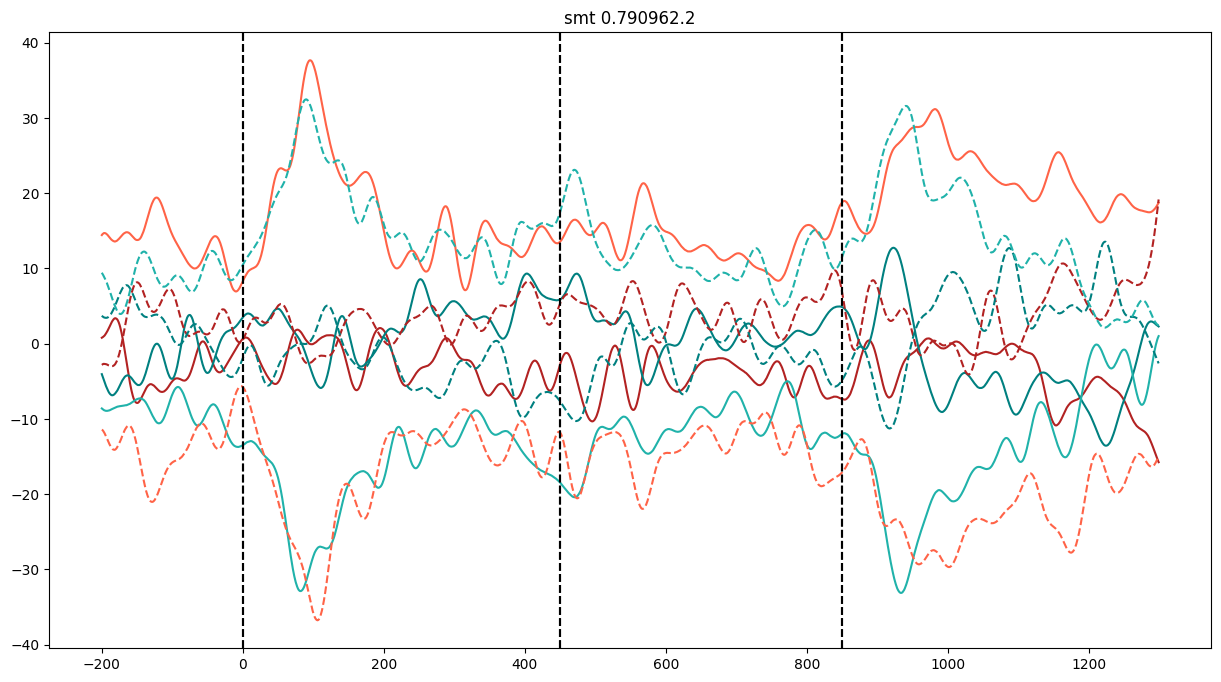

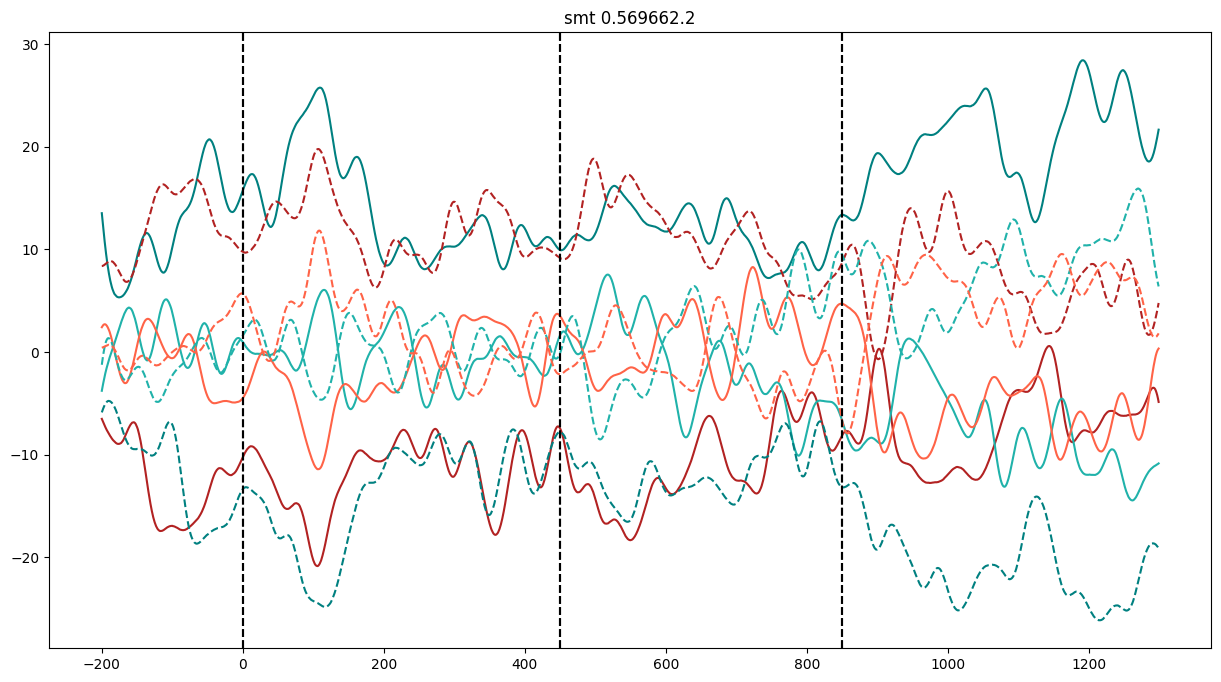

In [60]:
time = np.arange(T-400)-200
for i in range(Z.shape[0]):
    f,ax=plt.subplots(figsize=(15,8))
    #for i_r in range(2):
    color = task_constants.PALETTE_B1 #if i_r == 0 else {'o1_c1': 'grey', 'o1_c5': 'grey', 'o5_c5': 'k', 'o5_c1': 'k'}
    for i_m in range(2):
        lstyle = '-' if i_m == 0 else '--'
        for s in samples.keys():
            ax.plot(time,Z[i][samples[s]][i_m],color=color[s],linestyle=lstyle)
        max_v = np.max(Z[i][samples[s]])
        min_v = np.min(Z[i][samples[s]])
        ax.axvline(0,color='k',linestyle='--')
        ax.axvline(450,color='k',linestyle='--')
        ax.axvline(850,color='k',linestyle='--')
        ax.set(title='%s %f.2'%(which_marg[components[i]],variances['component_var'][components][i]))

In [73]:
X_full.shape

(44, 2, 2, 4, 1500)

In [74]:
# X_full2 = np.array(X_full)#.reshape(-1,1050)
# X_full2 =np.transpose(X_full2,(2,0,1,3))
# to_python_hdf5(dat=[{'pp':X_full2}], save_path='C:/Users/camil/Documents/int/dPCA-master/matlab/frlip.h5')

In [75]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
}

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

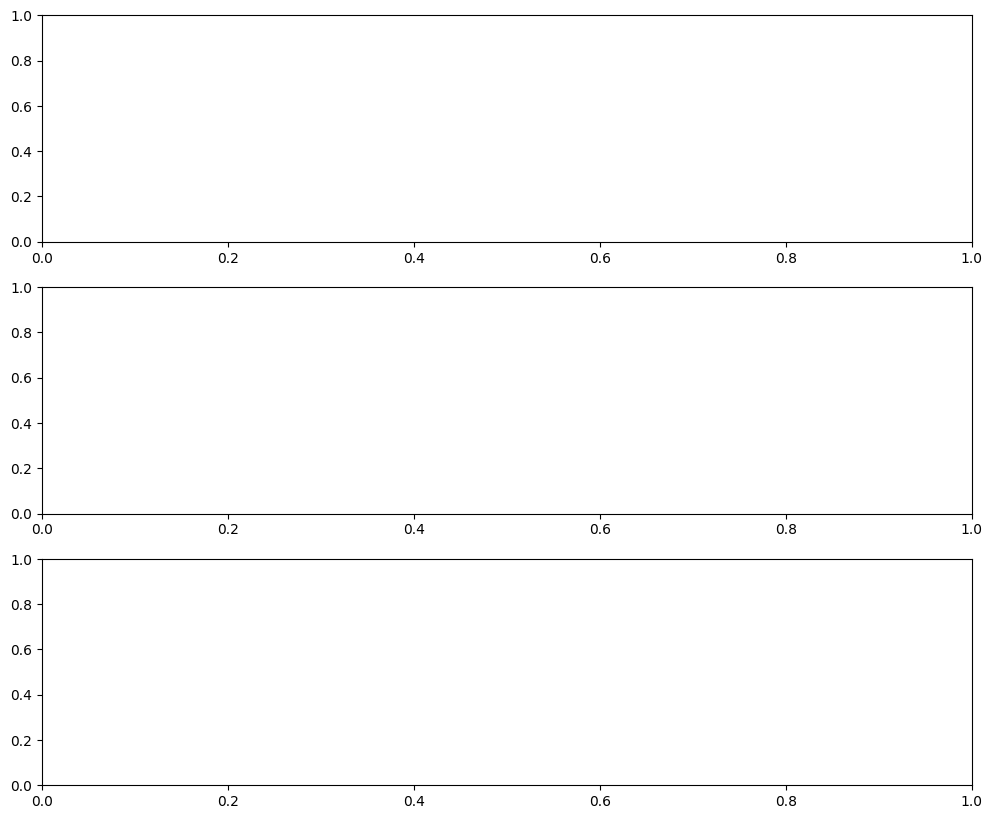

In [76]:
for c_type in ['t','s','st']:
    time = np.arange(T)+start
    f,ax=plt.subplots(3,1,figsize=(12,10))
    for s in samples.keys():
        ax[0].plot(time,Z[c_type][0,samples[s]],color=task_constants.PALETTE_B1[s])
        ax[1].plot(time,Z[c_type][1,samples[s]],color=task_constants.PALETTE_B1[s])
        ax[2].plot(time,Z[c_type][2,samples[s]],color=task_constants.PALETTE_B1[s])
    ax[0].set(title='%s component %d'%(c_type,0+1))
    ax[1].set(title='%s component %d'%(c_type,1+1))
    ax[2].set(title='%s component %d'%(c_type,2+1))




In [77]:
n_comp = 10
var_ratio = dpca.explained_variance_ratio_
print(np.array(var_ratio['s'][:n_comp])*100)
print(np.array(var_ratio['t'][:n_comp])*100)
print(np.array(var_ratio['st'][:n_comp])*100)
var_concat = np.concatenate([var_ratio['s'][:n_comp],var_ratio['t'][:n_comp],var_ratio['st'][:n_comp]])*100
comp_concat = np.concatenate([['s']*n_comp,['t']*n_comp,['st']*n_comp])

KeyError: 's'

In [ ]:
import pandas as pd

df=pd.DataFrame({'component':comp_concat,'variance':var_concat})
df=df.sort_values(by='variance',ascending=False)[:15]

81.46538999338588


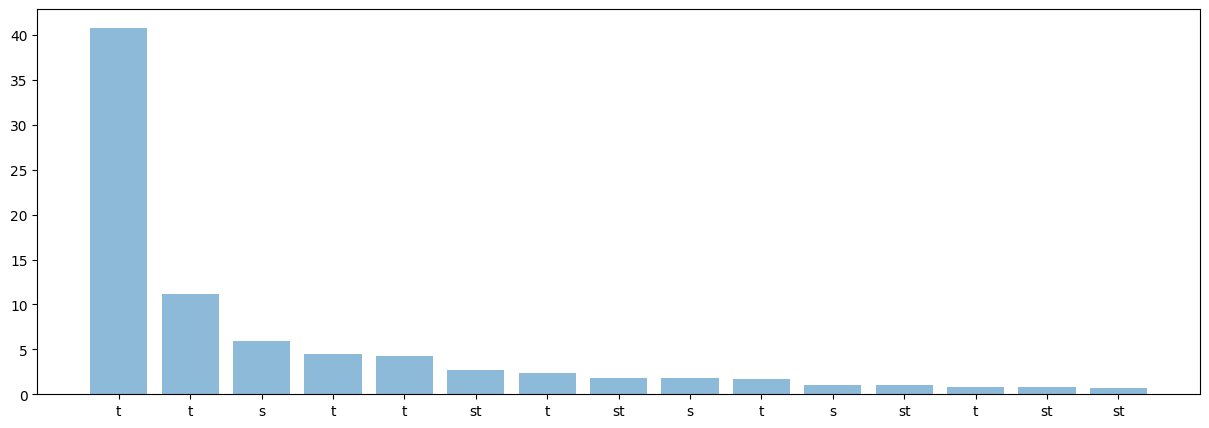

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(
    range(0, len(df)),
    df['variance'],
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
_=ax.set(xticks=(range(len(df))),xticklabels=df['component'].values)
print(df['variance'].sum())

In [ ]:
var_ratio = dpca.explained_variance_ratio_
var_ratio=np.sort(np.concatenate((var_ratio['s'],var_ratio['t'],var_ratio['st'])))[::-1]

In [ ]:
var_ratio

array([4.08280969e-01, 1.12204169e-01, 5.95223358e-02, 4.45894617e-02,
       4.23002821e-02, 2.66289419e-02, 2.39304790e-02, 1.85588081e-02,
       1.76679503e-02, 1.66881125e-02, 1.04638685e-02, 1.04571282e-02,
       8.42475791e-03, 8.39766382e-03, 6.53897273e-03, 6.01501720e-03,
       5.95815295e-03, 5.70525742e-03, 5.47601286e-03, 4.87392899e-03,
       4.54699133e-03, 4.22811961e-03, 3.94252003e-03, 3.79403461e-03,
       3.62898495e-03, 3.32444229e-03, 3.21128773e-03, 3.18417216e-03,
       2.98373606e-03, 2.89343289e-03, 2.73850608e-03, 2.51279264e-03,
       2.44265319e-03, 2.40505402e-03, 2.32509373e-03, 2.17852872e-03,
       2.08903174e-03, 2.06308572e-03, 2.02177366e-03, 1.96512544e-03,
       1.93378191e-03, 1.84049636e-03, 1.74279389e-03, 1.68084134e-03,
       1.61795101e-03, 1.55608662e-03, 1.52233901e-03, 1.50441782e-03,
       1.49203301e-03, 1.45173420e-03, 1.43887523e-03, 1.39783765e-03,
       1.35709710e-03, 1.31091489e-03, 1.23291537e-03, 1.21117340e-03,
      

lip: 13 components to explain 80% of the variance


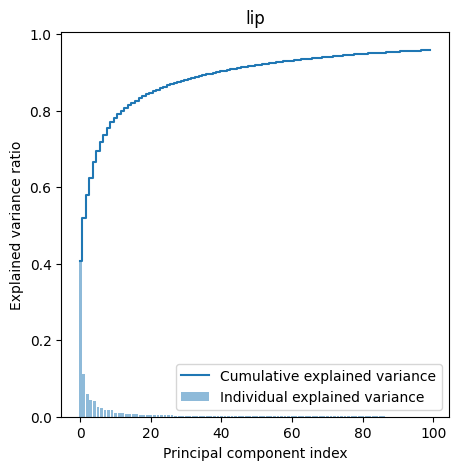

In [ ]:
figsize=(5,5)
fig, ax = plt.subplots(figsize=figsize)
exp_var_pca = var_ratio[:100]
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
ax.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
ax.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
ax.set(
    xlabel="Principal component index",
    ylabel="Explained variance ratio",
    title=area,
)
ax.legend(loc="best")
print(
    "%s: %d components to explain 80%% of the variance"
    % (area, np.where(cum_sum_eigenvalues > 0.8)[0][0])
)


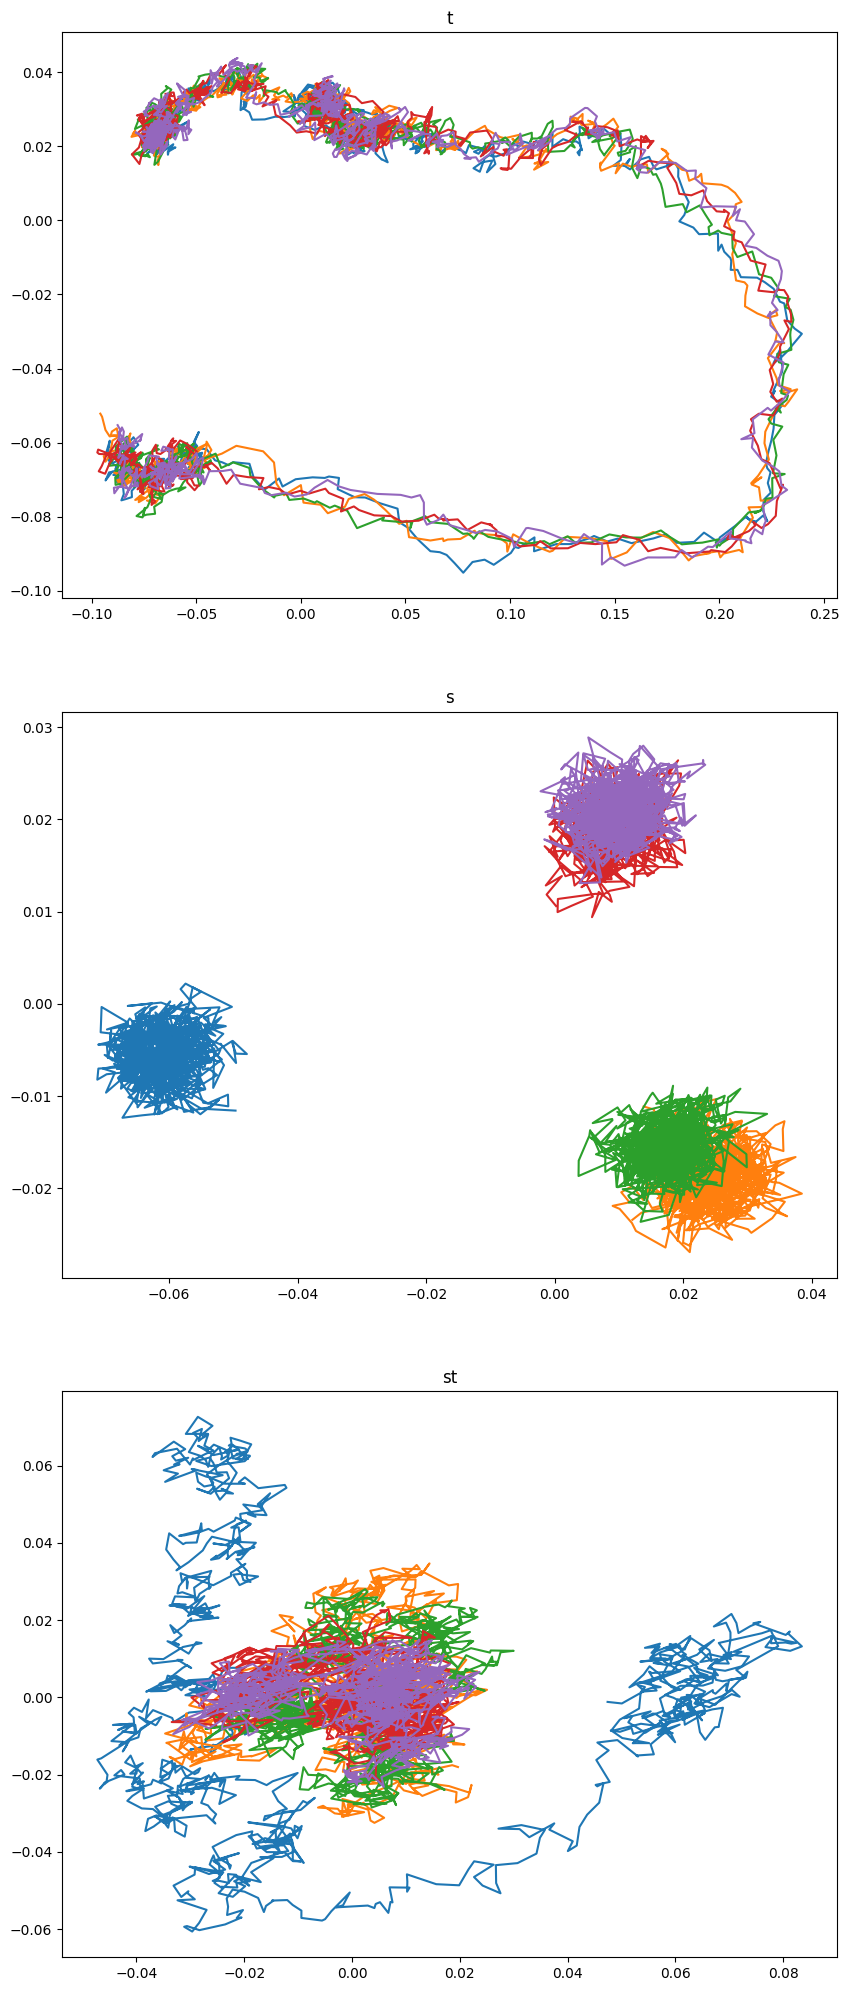

In [ ]:

time = np.arange(T)+start
f,ax=plt.subplots(3,1,figsize=(10,25))
for s in range(5):
    ax[0].plot(Z['t'][0,s],Z['t'][1,s])
    ax[0].set(title='t')
for s in range(5):
    ax[1].plot(Z['s'][0,s],Z['s'][1,s])
    ax[1].set(title='s')
for s in range(5):
    ax[2].plot(Z['st'][0,s],Z['st'][1,s])
    ax[2].set(title='st')
